# Neural Machine Translation by Jointly Learning to Align and Translate

Dzmitry Bahdanau, Kyunghyun Cho, Yoshua Bengio *ICLR 2015*

https://arxiv.org/pdf/1409.0473.pdf

In [1]:
import os
import re
from typing import List

from IPython.display import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

os.chdir(os.path.dirname(os.getcwd()))

## 0 Setup Sample Examples
Following examples are english to french translation sampled from [wmt14_translate](https://www.tensorflow.org/datasets/catalog/wmt14_translate#wmt14_translatefr-en). Our task is to train a model to translate english sentences to french.

In [2]:
sample_en = [
    "Crop insurance payments include only government crop insurance programs; private hail insurance payments are excluded.",
    "Activities of the second type will be a major determinant of the successful implementation of a language policy.",
    "There are no known natural sources of acrylonitrile.",
    "James recounts how the community was developed."
]
sample_fr = [
    "Les indemnités d’assurance-récolte comprennent uniquement celles des programmes publics; les indemnités de l’assurance-grêle privée sont exclues.",
    "Pour la mise en oeuvre, la deuxième catégorie d'activités constitue un déterminant essentiel du succès de la politique linguistique.",
    "On ne connaÃ®t aucune source naturelle d'acrylonitrile.",
    "Mme James raconte comment la collectivité a été créée."
]

### Preprocessing

In [3]:
def PreprocessSentence(sentence: str) -> str:
    """Preprocess an input sentence, make it cosumbale by the model."""
    sentence = sentence.lower().strip()
    # Add whitespace after certain special characters.
    sentence = re.sub(r"([,.?!$%'])", r" \1 ", sentence)
    # Add <start> and <end> token to sentence.
    sentence = "<start> " + sentence + " <end>"
    # Remove the redundant whitespaces.
    sentence = re.sub(r"[' ']+", " ", sentence)

    return sentence

In [4]:
sample_en = [PreprocessSentence(x) for x in sample_en]
sample_fr = [PreprocessSentence(x) for x in sample_fr]

print("Sample english sentences:")
for en in sample_en: print(en)
print("\nSample french sentences:")
for fr in sample_fr: print(fr)

Sample english sentences:
<start> crop insurance payments include only government crop insurance programs; private hail insurance payments are excluded . <end>
<start> activities of the second type will be a major determinant of the successful implementation of a language policy . <end>
<start> there are no known natural sources of acrylonitrile . <end>
<start> james recounts how the community was developed . <end>

Sample french sentences:
<start> les indemnités d’assurance-récolte comprennent uniquement celles des programmes publics; les indemnités de l’assurance-grêle privée sont exclues . <end>
<start> pour la mise en oeuvre , la deuxième catégorie d activités constitue un déterminant essentiel du succès de la politique linguistique . <end>
<start> on ne connaã®t aucune source naturelle d acrylonitrile . <end>
<start> mme james raconte comment la collectivité a été créée . <end>


### Tokenization

In [5]:
def GetTokenizer(sentences: List[str]) -> Tokenizer:
    """Create tokenizer."""
    tokenizer = Tokenizer(filters="", oov_token="<OOV>")
    tokenizer.fit_on_texts(sentences)
    
    return tokenizer

In [6]:
en_tokenizer = GetTokenizer(sample_en)
en_vocab_size = len(en_tokenizer.word_index)
en_sequences = en_tokenizer.texts_to_sequences(sample_en)
print(f"English vocab size: {en_vocab_size}\n")
print(en_tokenizer.word_index)
print(f"\nInput sequences:")
for seq in en_sequences: print(seq)
print("\n")
fr_tokenizer = GetTokenizer(sample_fr)
fr_vocab_size = len(fr_tokenizer.word_index)
fr_sequences = fr_tokenizer.texts_to_sequences(sample_fr)
print(f"French vocab size: {fr_vocab_size}\n")
print(fr_tokenizer.word_index)
print(f"\nTarget sequences:")
for seq in fr_sequences: print(seq)

English vocab size: 41

{'<OOV>': 1, '<start>': 2, '.': 3, '<end>': 4, 'of': 5, 'insurance': 6, 'the': 7, 'crop': 8, 'payments': 9, 'are': 10, 'a': 11, 'include': 12, 'only': 13, 'government': 14, 'programs;': 15, 'private': 16, 'hail': 17, 'excluded': 18, 'activities': 19, 'second': 20, 'type': 21, 'will': 22, 'be': 23, 'major': 24, 'determinant': 25, 'successful': 26, 'implementation': 27, 'language': 28, 'policy': 29, 'there': 30, 'no': 31, 'known': 32, 'natural': 33, 'sources': 34, 'acrylonitrile': 35, 'james': 36, 'recounts': 37, 'how': 38, 'community': 39, 'was': 40, 'developed': 41}

Input sequences:
[2, 8, 6, 9, 12, 13, 14, 8, 6, 15, 16, 17, 6, 9, 10, 18, 3, 4]
[2, 19, 5, 7, 20, 21, 22, 23, 11, 24, 25, 5, 7, 26, 27, 5, 11, 28, 29, 3, 4]
[2, 30, 10, 31, 32, 33, 34, 5, 35, 3, 4]
[2, 36, 37, 38, 7, 39, 40, 41, 3, 4]


French vocab size: 51

{'<OOV>': 1, '<start>': 2, '.': 3, '<end>': 4, 'la': 5, 'les': 6, 'indemnités': 7, 'de': 8, 'd': 9, 'd’assurance-récolte': 10, 'comprennent': 

### Padding
Pad the sequences by 0 to get same sequence_length.

In [7]:
def Padding(sequences: List[List[int]]) -> List[List[int]]:
    """Pad sequences."""
    padded = tf.keras.preprocessing.sequence.pad_sequences(
        sequences, padding="post")
    
    return padded

In [8]:
en_sequences = Padding(en_sequences)
max_input_len = len(en_sequences[0])
print(f"Padded input sequences:")
for seq in en_sequences: print(seq)
print(f"max_input_len: {max_input_len}")
      
fr_sequences = Padding(fr_sequences)
max_target_len = len(fr_sequences[0])
print(f"\nPadded target sequences:")
for seq in fr_sequences: print(seq)
print(f"max_target_len: {max_target_len}")

Padded input sequences:
[ 2  8  6  9 12 13 14  8  6 15 16 17  6  9 10 18  3  4  0  0  0]
[ 2 19  5  7 20 21 22 23 11 24 25  5  7 26 27  5 11 28 29  3  4]
[ 2 30 10 31 32 33 34  5 35  3  4  0  0  0  0  0  0  0  0  0  0]
[ 2 36 37 38  7 39 40 41  3  4  0  0  0  0  0  0  0  0  0  0  0]
max_input_len: 21

Padded target sequences:
[ 2  6  7 10 11 12 13 14 15 16  6  7  8 17 18 19 20  3  4  0  0  0  0  0]
[ 2 21  5 22 23 24 25  5 26 27  9 28 29 30 31 32 33 34  8  5 35 36  3  4]
[ 2 37 38 39 40 41 42  9 43  3  4  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 2 44 45 46 47  5 48 49 50 51  3  4  0  0  0  0  0  0  0  0  0  0  0  0]
max_target_len: 24


## Abstract
Current models usually choose a encoder-decoder architecture. The encoder encodes a source sequence into a fixed-length hidden state from which a decoder generates a target sequence. The paper argues that the use of a fixed-length hidden state is a bottleneck in improving the performance. The paper, instead, proposes a (soft-)search for parts of a source sequence that are relevant to predicting a target word. (i.e. the target word should "pay attention" to certain input words.)

## 1 Introduction & Background
***Neural machine translation*** attempts to build and train **a single, large neural network** that reads a sentence and outputs a correct translation. (While tradation phtrase-based systems are usually consist of many sub-components that are tuned separately.) 

Most of the proposed models belong to a family of ***encoder-decoders***
 - [Sequence to sequence learning with neural networks](https://arxiv.org/pdf/1409.3215.pdf) Ilya Sutskever, Oriol Vinyals, and Quoc V.Le *NIPS 2014* **(Seq2Seq)**
 - [ Learning phrase representations using rnn encoder-decoder for statistical machine translation](https://arxiv.org/pdf/1406.1078.pdf) Kyunghyun Cho, Yoshua Bengio *CoRR 2014* **(Enc-Dec)**
 
A potential issue with this approach lies on the fact that all necessary information of a source sequence need to be compressed into a fixed-length vector (hidden state). This makes it hard for the model to cope with long sentences. Following paper showed that the performance of a basic encoder-decoder deteriorates rapidly as the length of an input sentence increases.
 
 - [On the Properties of Neural Machine Translation: Encoder-Decoder Approaches](https://arxiv.org/pdf/1409.1259.pdf) Kyunghyun Cho, Bart van Merrienboer, Dzmitry Bahdanau, Yoshua Bengio *SSST-8 2014*
 
To address the issue, the paper introduces attention mechanism. The model encodes the input sequence into context vectors Each time step the decoder predicts based on the context vectors and previous decoder state.

## 2 Model Architecture

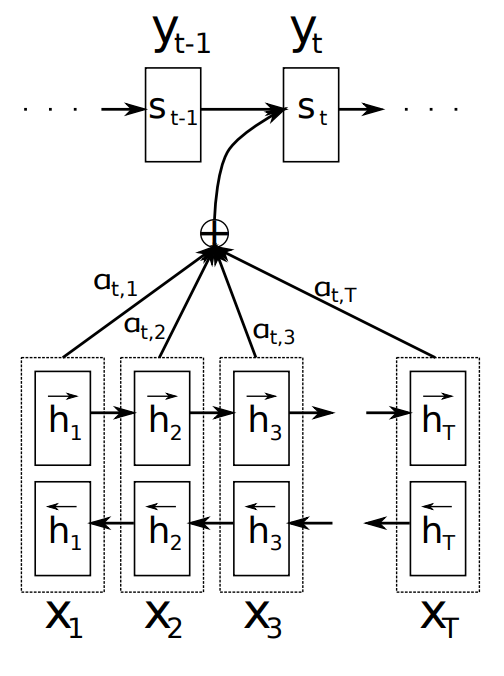

In [9]:
Image(filename='notebooks/figures/bahdanau_attention.png')

### 2.1 Encoder
Paper chooses a bidirectional-GRU structure to take care of both preceding and following words.

The forward GRU encodes input sequence into *forward hidden states* $(\overrightarrow{h}_1, ..., \overrightarrow{h}_{T_x})$.

The backward GRU encodes input sequence into *backward hidden states* $(\overleftarrow{h}_1, ..., \overleftarrow{h}_{T_x})$.

The hidden vector for each token $x_j$ is then the concatenation of forward and backward state.

$$h_j=[\overrightarrow{h}_j^T,\overleftarrow{h}_j^T]^T$$

In the paper `emb_size=600`, `hidden_size=1000`

In [10]:
def Encoder(input_vocab_size: int, 
            emb_size: int, 
            hidden_size: int, 
            name: str="encoder"):
    """Bi-directional GRU encoder.

    Inputs:
        sequences: Indices of input sequence tokens, of shape 
            (batch_size, input_seq_len)
    Args:
        input_vocab_size: Size of input vocab.
        emb_size: Dimensionality of the embeddings.
        hidden_size: Dimensionality of the layers.
        name: Name of the Encoder.
    Returns:
        Encoder output, of shape (batch_size, input_seq_len, hidden_size)
        Last encoder state, of shape (batch_size, hidden_size)
    """
    sequences = tf.keras.Input(shape=(None, ), name="input_sequences")
    
    embedding_layer = tf.keras.layers.Embedding(input_dim=input_vocab_size, 
                                                output_dim=emb_size)
    bi_gru_layer = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(units=hidden_size, 
                            return_sequences=True,
                            return_state=True))
    reduce_states = tf.keras.layers.Dense(hidden_size)
    
    # Embedding layer. (batch_size, input_seq_len, emb_size)
    embeddings = embedding_layer(sequences)
    # Bi-GRU layer. 
    #  - encoder_outputs: (batch_size, input_seq_len, hidden_size*2)
    #  - forward_state: (batch_size, hidden_size)
    #  - backward_state: (batch_size, hidden_size)
    encoder_output, forward_state, backward_state = bi_gru_layer(embeddings)
    # Reduce the forward and backward state into a single initial state for the 
    # decoder since decoder is not Bi-directional. (batch_size, hidden_size)
    state = reduce_states(tf.concat([forward_state, backward_state], axis=1))
    
    return tf.keras.Model(
      inputs=[sequences], outputs=[encoder_output, state], name=name)

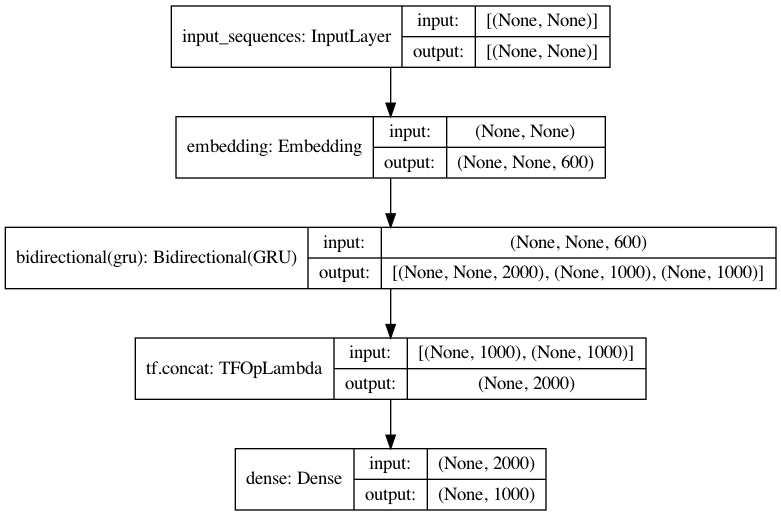

In [11]:
# Example
EMB_SIZE = 600
HIDDEN_SIZE = 1000
encoder = Encoder(input_vocab_size=en_vocab_size+1, # +1 for padding 
                  emb_size=EMB_SIZE, 
                  hidden_size=HIDDEN_SIZE)
encoder_output, encoder_state = encoder(en_sequences)
tf.keras.utils.plot_model(encoder, show_shapes=True)

### 2.2 Masking
#### Padding mask
Mask all the pad tokens in the batch of sequences, to make sure the model doesn't treat paddings as inputs.

In [12]:
def GetPaddingMask(sequences: tf.Tensor) -> tf.Tensor:
    """ Create padding mask.
    
    Args:
        sequences: input sequences, of shape (batch_size, seq_len)
    Returns:
        mask: mask tensor of shape (batch_size, seq_len)
    """
    mask = tf.cast(tf.not_equal(sequences, tf.constant(0)), tf.float32)
    
    return mask

In [13]:
# Example
input_padding_mask = GetPaddingMask(en_sequences)
print("Input padding mask:")
print(input_padding_mask)

Input padding mask:
tf.Tensor(
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(4, 21), dtype=float32)


### 2.3 Bahdanau attention

For timestep $i$, given $s_{i-1}$ is the hidden state from previous decoding step and $h=\{h_j\}$ are encoder outputs

The attention is calculated in three steps:

- **Score** Q (hidden state in previous decoding steps) and K (encoder outputs)

$$e_{ij}=W_a\tanh(W_ss_{t-1}+W_hh))$$

- **Aignment** with softmax to get attention weights

$$\alpha_{ij}=\frac{exp(e_{ij})}{\sum_{k=1}^{T_X}exp(e_{ik})}$$

- **Calculate Attention** as weighted sum of V (encoder outputs)

$$c_i=\sum_{j=1}^{T_x}\alpha_{ij}h_j$$

In [1]:
class BahdanauAttention(tf.keras.layers.Layer):
    """ Bahdanau attention layer.
    
    Args:
        hidden_size: Dimensionality of the layers.
        name: Name of the layer.
    """
    def __init__(self, hidden_size: int, name: str="attention"):
        super(BahdanauAttention, self).__init__(name=name)
        self.query_linear = tf.keras.layers.Dense(units=hidden_size)
        self.value_linear = tf.keras.layers.Dense(units=hidden_size)
        self.score_linear = tf.keras.layers.Dense(units=1)
        
    def call(self, 
             query: tf.Tensor, 
             values: tf.Tensor, 
             input_padding_mask: tf.Tensor):
        """
        Args:
            query: The query tensor of shape (batch_size, hidden_size)
            values: The query tensor of shape (batch_size, input_seq_len, hidden_size*2)
            input_padding_mask: The mask tensor of shape (batch_size, input_seq_len)
        """
        q = self.query_linear(tf.expand_dims(query, 1))
        v = self.value_linear(values)
        
        # Attention - Score (Additive attention), of shape (batch_size, input_seq_len, 1)
        score = self.score_linear(tf.nn.tanh(q+v))
        # Attention - Alignment
        #  - Softmax on the second axis (input_seq_len) so that the scores add up to 1.
        attention_weights = tf.nn.softmax(score, axis=1)
        #  - Mask the paddings in encoder sequence so their are not included in the attentions.
        input_padding_mask = tf.expand_dims(input_padding_mask, axis=-1)
        attention_weights *= tf.cast(input_padding_mask, tf.float32)
        # Attention - Calculate context vector, of shape (batch_size, 1, hidden_dim)
        context_vector = attention_weights * v
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, tf.squeeze(attention_weights, axis=-1)

NameError: name 'tf' is not defined

In [79]:
# Example
attention = BahdanauAttention(hidden_size=HIDDEN_SIZE)
context_vector, attention_weights = attention(
    query=encoder_state, values=encoder_output, input_padding_mask=input_padding_mask)
print("Context vector:")
print(context_vector)
print("\nattention weights:")
print(attention_weights)

Context vector:
tf.Tensor(
[[ 0.00404111 -0.0045807  -0.00494379 ...  0.00400811  0.00309866
  -0.00029379]
 [-0.00353365 -0.00117155 -0.00328346 ... -0.00913731 -0.00029068
   0.00324635]
 [-0.00315115  0.00049465 -0.00398366 ... -0.00312585  0.00374092
  -0.00265977]
 [-0.00322528  0.00169331 -0.0043174  ... -0.00165958  0.00505419
  -0.00148795]], shape=(4, 1000), dtype=float32)

attention weights:
tf.Tensor(
[[0.0474827  0.0474183  0.04720105 0.04653763 0.04718866 0.04691042
  0.04680812 0.04731815 0.04694678 0.04774386 0.04844686 0.04764256
  0.04736694 0.0464147  0.04658977 0.04661003 0.04794831 0.04894756
  0.         0.         0.        ]
 [0.04758015 0.04819012 0.04696296 0.0481672  0.04699526 0.04825396
  0.04770643 0.04716619 0.04707402 0.0468537  0.04709256 0.04692278
  0.04828013 0.04881532 0.04812695 0.04649607 0.04669916 0.04717881
  0.0484485  0.04820438 0.04878544]
 [0.04678432 0.04689669 0.04626819 0.04653744 0.04607386 0.04660594
  0.04772871 0.0463578  0.04730281 0

### 2.4 Decoder

The decoder defines a probability over the translation $y$ by decomposing the joint probability

$$p(y)=\sum_{i=1}^{T_y}p(y_i|\{y_1, ..., y_{t-1}\}, c)$$

With an RNN, each conditional probability is modeled as

$$p(y_i|\{y_1, ..., y_{t-1}\}, c)=RNN(y_{t-1}, s_{t-1}, c)$$

The decoder first get context_vector with ($s_{t-1}$, $c$), then concatenate it with the embeddings of target token and feed into the RNN

In [86]:
def Decoder(target_vocab_size: int, 
            emb_size: int, 
            hidden_size: int, 
            name: str="decoder"):
    """GRU decoder.

    Inputs:
        sequences: Indices of target sequence tokens, of shape 
            (batch_size, 1)
        decoder_hidden: hidden state from previous decode step.
            of shape (batch_size, hidden_size)
        encoder_output: of shape (batch_size, input_seq_len, hidden_size)
        input_padding_mask: The mask tensor of shape (batch_size, input_seq_len)
    Args:
        target_vocab_size: Size of target vocab.
        emb_size: Dimensionality of the embeddings.
        hidden_size: Dimensionality of the layers.
        name: Name of the Decoder.
    Returns:
        Decoder output, of shape (batch_size, target_vocab_size)
        Last decoder state, of shape (batch_size, hidden_size)
        attention weights of shape (batch_size, input_seq_len)
    """
    sequences = tf.keras.Input(shape=(1, ), name="target_sequences")
    decoder_hidden = tf.keras.Input(shape=(hidden_size, ), name="decoder_hidden")
    encoder_output = tf.keras.Input(shape=(None, hidden_size*2), name="encoder_output")
    input_padding_mask = tf.keras.Input(shape=(None, ), name="mask")
    
    embedding_layer = tf.keras.layers.Embedding(input_dim=target_vocab_size, 
                                                output_dim=emb_size)
    attention_layer = BahdanauAttention(hidden_size=hidden_size)
    gru_layer = tf.keras.layers.GRU(units=hidden_size, 
                                    return_sequences=True,
                                    return_state=True)
    output_linear = tf.keras.layers.Dense(target_vocab_size)
    
    # Embedding layer. (batch_size, 1, emb_size)
    embeddings = embedding_layer(sequences)
    
    # Attention of shape (batch_size, hidden_dim)
    context_vector, attention_weights = attention_layer(query=decoder_hidden, 
                                                        values=encoder_output, 
                                                        input_padding_mask=input_padding_mask)
    
    # Concat embeddings and context vector, of shape (batch_size, 1, emb_size + hidden_size)
    decoder_input = tf.concat([tf.expand_dims(context_vector, 1), embeddings], axis=-1)
    
    # GRU layer. 
    #  - gru_outputs: (batch_size, 1, hidden_size)
    #  - state: (batch_size, hidden_size)
    gru_output, state = gru_layer(decoder_input)
    
    # Get decoder output 
    gru_output = tf.reshape(gru_output, (-1, hidden_size))
    decoder_output = output_linear(gru_output)
    
    return tf.keras.Model(
      inputs=[sequences, decoder_hidden, encoder_output, input_padding_mask], 
        outputs=[decoder_output, state, attention_weights], name=name)

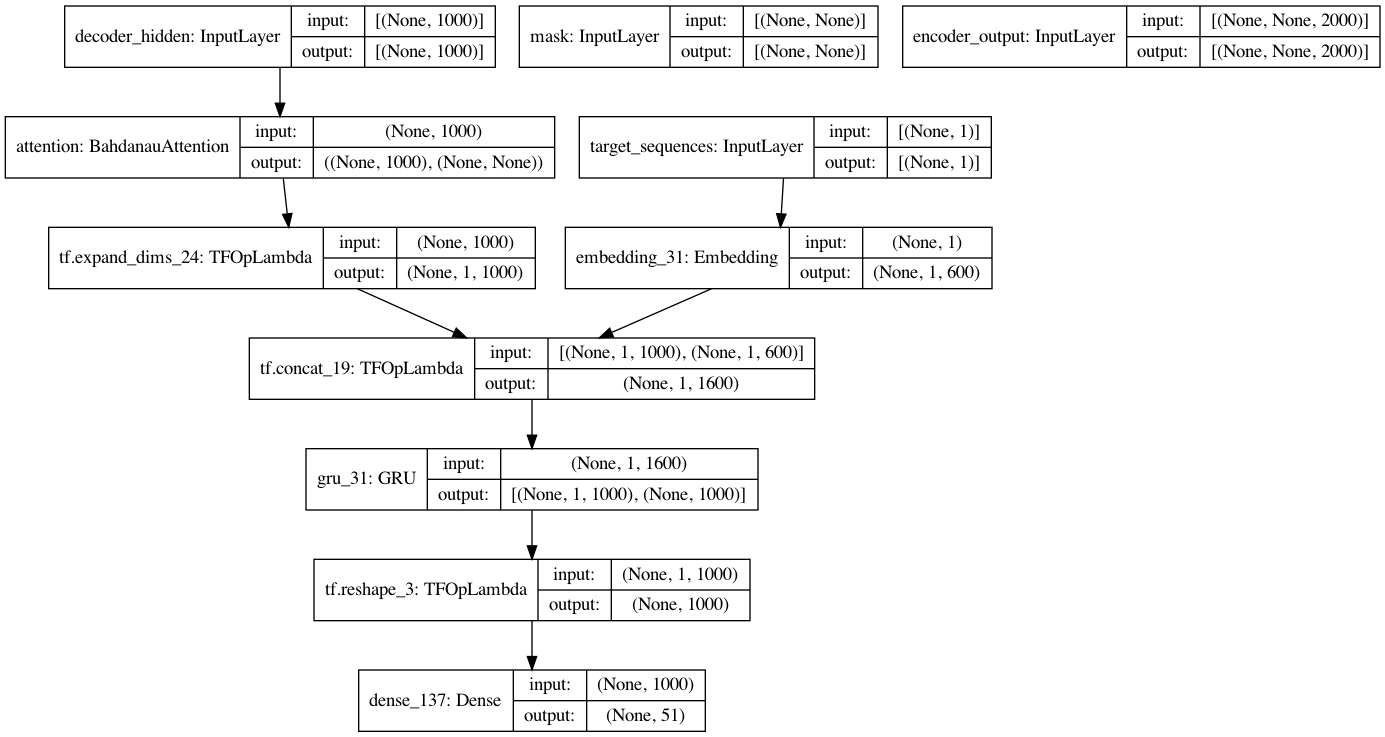

In [115]:
# Example
decoder = Decoder(target_vocab_size=fr_vocab_size, 
                  emb_size=EMB_SIZE, 
                  hidden_size=HIDDEN_SIZE)
decoder_output, state, attention_weights = decoder(
    [fr_sequences[:, :1], encoder_state, encoder_output, input_padding_mask])
tf.keras.utils.plot_model(decoder, show_shapes=True)